In [47]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note id,person id,age,gender source value,BMI,admission department,division,ward,asa class,surgeon id,...,condition source value,surgery room,previous surgery,emergency status,op timing,day of the week,week of the month,month,surgeon estimated op time,surgery duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161214,297111,4055249,1,M,23.700428,Pediatric Surgery,Admission,5A,1,100613,...,D00011688,5,N,Y,etc,Tuesday,2,September,200,123
161215,297455,4055328,1,M,20.612160,Pediatric Urology,Day,PDSC,1,6259,...,D00016707,7,N,N,8A,Monday,4,September,130,45
161216,297761,4055407,1,M,12.502703,Pediatric Surgery,Admission,5A,2,105057,...,D00011524,5,N,N,8A,Wednesday,3,September,130,43
161217,297753,4055558,4,F,14.365794,Pediatric Surgery,Admission,5A,2,105057,...,D00004831,5,N,N,TF6,Wednesday,3,September,130,82


In [48]:
from sklearn.model_selection import train_test_split

# Removing unnecessary columns
df.drop(columns=['note id', 'person id', 'surgeon estimated op time', 'final op name'], inplace=True)

# Encoding binary columns
binary_cols = ['condition source value']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding for other categorical columns
one_hot_cols = ['surgical department', 'op timing', 'month', 'anesthesia type', 'op code',
                'day of the week', 'asa class', 'week of the month', 
                'division', 'previous surgery', 'emergency status', 'gender source value', 'surgeon id', 'ward', 
                'admission department', 'surgery room']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Splitting the data
X_all = df_encoded.drop("surgery duration", axis=1)
y_all = df_encoded["surgery duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all
y_train_all


61344     122
137241     48
139478     76
113549     36
149411    127
         ... 
119879     76
103694     57
131932    311
146867     82
121958     57
Name: surgery duration, Length: 128975, dtype: int64

In [49]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Preparing department-specific datasets
departments = df['surgical department'].unique()
department_models = {}
predictions = {}

# Training models for each department
for dept in departments:
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Filtering data for the department
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']

    # Splitting the data
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # Training the model
    department_model = DecisionTreeRegressor(random_state=42)
    department_model.fit(X_train_dept, y_train_dept)
    department_models[dept] = department_model

    # Making predictions on the test dataset
    predictions[dept] = department_model.predict(X_test_dept)

# Preparing for ensemble
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# Applying each department-specific model to the entire test dataset
for dept, department_model in department_models.items():
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Indices of test data belonging to the department
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # Calculating predictions for the department
    dept_predictions = department_model.predict(X_test_all.loc[dept_indices])

    # Updating the final prediction array
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# Evaluating performance
mae_dt = mean_absolute_error(y_test_all, final_predictions)
rmse_dt = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_dt = r2_score(y_test_all, final_predictions)

# The code is now updated with model names changed to 'department_model'
mae_dt, rmse_dt, r2_dt

(8.635280982508373, 32.8354048767889, 0.9094745086880096)

In [4]:
# Analyzing errors for each department-specific model

# Calculating errors for each department
department_errors = {}
for dept, model in department_models.items():
    dept_col_name = 'surgical department_' + dept
    X_test_dept = X_test_all[X_test_all[dept_col_name] == 1]
    y_test_dept = y_test_all.loc[X_test_dept.index]
    dept_predictions = model.predict(X_test_dept)
    dept_mae = mean_absolute_error(y_test_dept, dept_predictions)
    dept_rmse = np.sqrt(mean_squared_error(y_test_dept, dept_predictions))
    department_errors[dept] = {'MAE': dept_mae, 'RMSE': dept_rmse}

# Identifying departments with high error rates
high_error_departments = {dept: errors for dept, errors in department_errors.items() if errors['MAE'] > mae_dt or errors['RMSE'] > rmse_dt}

high_error_departments



{'General Surgery': {'MAE': 9.146243969676085, 'RMSE': 31.970480871264723},
 'Otolaryngology': {'MAE': 10.309216192937123, 'RMSE': 40.214980003845994},
 'Orthopedics': {'MAE': 10.346662657847263, 'RMSE': 39.45034633075299},
 'Obstetrics & Gynecology': {'MAE': 9.886196451752488,
  'RMSE': 32.99906899805218},
 'Plastic Surgery': {'MAE': 10.053134328358208, 'RMSE': 38.22955799479785},
 'Neurosurgery': {'MAE': 13.16542372881356, 'RMSE': 45.31752383021048},
 'Cardiovascular Thoracic Surgery': {'MAE': 12.78141499472017,
  'RMSE': 42.330561677746935},
 'Pediatric Orthopedics': {'MAE': 12.141592920353983,
  'RMSE': 46.616112524562304},
 'Pediatric Thoracic Surgery': {'MAE': 12.026041666666666,
  'RMSE': 39.159728995487185},
 'Pediatric Neurosurgery': {'MAE': 14.32618025751073,
  'RMSE': 53.62723028766431}}

In [5]:
from sklearn.model_selection import GridSearchCV

# Setting up the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Creating a new Decision Tree Regressor for tuning
tuning_model = DecisionTreeRegressor(random_state=42)

# Setting up the grid search with cross-validation
grid_search = GridSearchCV(estimator=tuning_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=2)

# Training using GridSearchCV
grid_search.fit(X_train_dept, y_train_dept)

# Best parameters
best_params = grid_search.best_params_
best_params


Fitting 3 folds for each of 108 candidates, totalling 324 fits


c:\Users\iamgu\Documents\GitHub\Surgical-Duration-Prediction\surgical\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
162 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
84 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\iamgu\Documents\GitHub\Surgical-Duration-Prediction\surgical\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\iamgu\Documents\GitHub\Surgical-Duration-Prediction\surgical\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\iamgu\Documents\GitHub\Surgical-

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10}

In [37]:
# Updating the code to train department-specific Decision Tree Regressor models with new hyperparameters

# New hyperparameters
new_params = {
    'max_depth': None,  # No maximum depth
    'max_features': None,  # Max features to consider for best split: 'sqrt'
    'min_samples_leaf': 1,  # Minimum samples required at a leaf node
    'min_samples_split': 2  # Minimum samples required to split a node
}

# Training department-specific models with the new hyperparameters
new_department_models = {}
new_predictions = {}

for dept in departments:
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Filtering data for the department
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']

    # Splitting the data
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # Training the model with new hyperparameters
    new_department_model = DecisionTreeRegressor(
        max_depth=new_params['max_depth'],
        max_features=new_params['max_features'],
        min_samples_leaf=new_params['min_samples_leaf'],
        min_samples_split=new_params['min_samples_split'],
        random_state=42
    )
    new_department_model.fit(X_train_dept, y_train_dept)
    new_department_models[dept] = new_department_model

    # Making predictions on the test dataset
    new_predictions[dept] = new_department_model.predict(X_test_dept)

# Preparing for ensemble
new_final_predictions = np.zeros(len(X_test_all))
new_test_indices = X_test_all.index

# Applying each department-specific model to the entire test dataset
for dept, new_department_model in new_department_models.items():
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Indices of test data belonging to the department
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # Calculating predictions for the department
    new_dept_predictions = new_department_model.predict(X_test_all.loc[dept_indices])

    # Updating the final prediction array
    new_final_predictions[np.isin(new_test_indices, dept_indices)] = new_dept_predictions

# Evaluating performance of the new models
new_mae_dt = mean_absolute_error(y_test_all, new_final_predictions)
new_rmse_dt = np.sqrt(mean_squared_error(y_test_all, new_final_predictions))
new_r2_dt = r2_score(y_test_all, new_final_predictions)

new_mae_dt, new_rmse_dt, new_r2_dt



(8.635280982508373, 32.8354048767889, 0.9094745086880096)

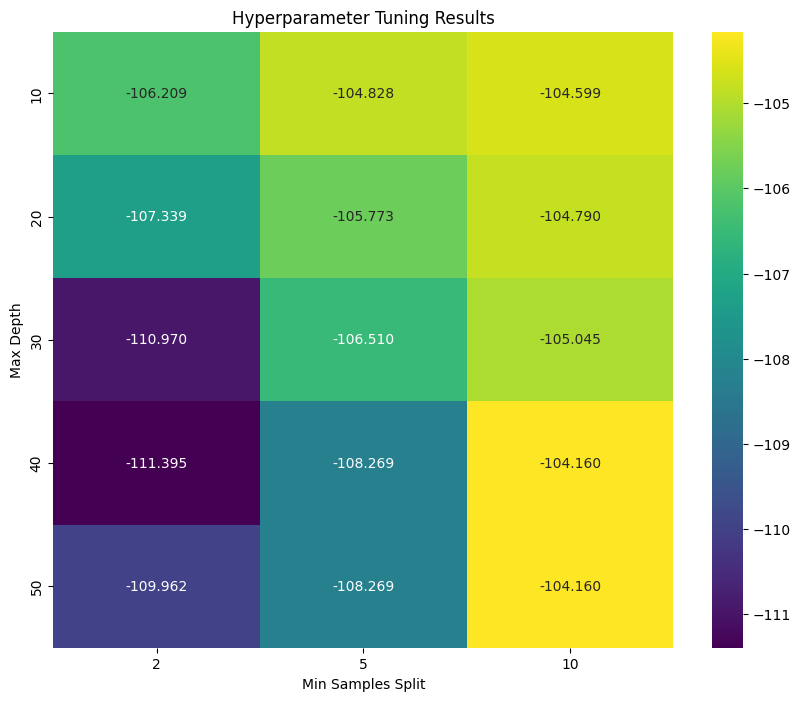

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'grid_search' is your GridSearchCV object
results = pd.DataFrame(grid_search.cv_results_)

# Create a pivot table of mean test scores for each combination of 'max_depth' and 'min_samples_split'
pivot_table = results.pivot_table(values='mean_test_score', 
                                  index='param_max_depth', 
                                  columns='param_min_samples_split')

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".3f")
plt.title('Hyperparameter Tuning Results')
plt.xlabel('Min Samples Split')
plt.ylabel('Max Depth')
plt.show()


In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming df_encoded is your dataset and departments is the list of departments
department_optimal_params = {}
department_performance = {}

for dept in departments:
    # Prepare the data for the department
    dept_col_name = 'surgical department_' + dept
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration']
    
    # Split the data
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # Define the hyperparameter grid
    param_grid = {
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt']
    }

    # Perform Grid Search
    grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train_dept, y_train_dept)

    # Store the best parameters and model performance
    best_params = grid_search.best_params_
    department_optimal_params[dept] = best_params

    # Train the model with the best parameters
    best_model = DecisionTreeRegressor(**best_params, random_state=42)
    best_model.fit(X_train_dept, y_train_dept)
    predictions = best_model.predict(X_test_dept)

    # Evaluate the model
    mae = mean_absolute_error(y_test_dept, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_dept, predictions))
    r2 = r2_score(y_test_dept, predictions)

    department_performance[dept] = {'MAE': mae, 'RMSE': rmse, 'R²': r2}

# Now, department_optimal_params contains the best hyperparameters for each department
# And department_performance contains the performance metrics for each department


c:\Users\iamgu\Documents\GitHub\Surgical-Duration-Prediction\surgical\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
162 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
129 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\iamgu\Documents\GitHub\Surgical-Duration-Prediction\surgical\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\iamgu\Documents\GitHub\Surgical-Duration-Prediction\surgical\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\iamgu\Documents\GitHub\Surgical

In [52]:
import numpy as np

# Split the full dataset (if not already split)
X_all = df_encoded.drop('surgery duration', axis=1)
y_all = df_encoded['surgery duration']
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Reset indices to avoid indexing issues
X_train_all.reset_index(drop=True, inplace=True)
X_test_all.reset_index(drop=True, inplace=True)
y_train_all.reset_index(drop=True, inplace=True)
y_test_all.reset_index(drop=True, inplace=True)

# 전체 테스트 세트에 대한 최종 예측을 준비
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# 각 부서별 모델을 전체 테스트 데이터셋에 적용
for dept, best_params in department_optimal_params.items():
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # 해당 부서에 해당하는 테스트 데이터 인덱스
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # 해당 부서의 최적화된 모델로 예측 수행
    best_model = DecisionTreeRegressor(**best_params)
    best_model.fit(X_train_all.loc[dept_indices], y_train_all.loc[dept_indices])
    dept_predictions = best_model.predict(X_test_all.loc[dept_indices])

    # 최종 예측 배열에 해당 부분 업데이트
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# 전체적인 성능 평가
total_mae = mean_absolute_error(y_test_all, final_predictions)
total_rmse = np.sqrt(mean_squared_error(y_test_all, final_predictions))
total_r2 = r2_score(y_test_all, final_predictions)

total_mae, total_rmse, total_r2


(97.05522946572894, 142.76470301297977, -0.7113066246811923)

TypeError: 'value' must be an instance of str or bytes, not a int

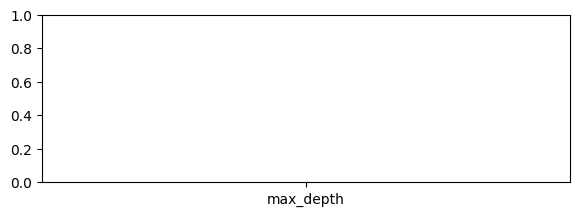

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'department_optimal_params' and 'department_performance' are your results

# Plotting the Optimal Hyperparameters for Each Department
plt.figure(figsize=(15, 10))
for idx, (dept, params) in enumerate(department_optimal_params.items()):
    plt.subplot(len(department_optimal_params), 2, 2*idx+1)
    sns.barplot(x=list(params.keys()), y=list(params.values()))
    plt.title(f'{dept} - Optimal Hyperparameters')
    plt.ylabel('Parameter Value')
    plt.xlabel('Parameter')

# Plotting the Model Performance for Each Department
for idx, (dept, perf) in enumerate(department_performance.items()):
    plt.subplot(len(department_performance), 2, 2*idx+2)
    sns.lineplot(x=list(perf.keys()), y=list(perf.values()), marker='o')
    plt.title(f'{dept} - Model Performance')
    plt.ylabel('Performance Metric')
    plt.xlabel('Metric')

plt.tight_layout()
plt.show()
